# CDP Ngram Viewer

One of the interesting things we can do with CDP data is look at trends in discussion by keyword.
Much like [Google's Ngram Viewer](https://books.google.com/ngrams) we can plot these trends over time.

## Ngram Usage over Time

To generate a plot using the same process as Google's Ngram Viewer, we must download and then process transcripts for each instance we wish to analyze -- there is no stored data in the instance for us to use.

In [1]:
from cdp_data import CDPInstances
from cdp_data.keywords import compute_ngram_usage_history
seattle_ds = compute_ngram_usage_history(CDPInstances.Seattle)

# Cache to disk because this takes a couple of minutes to compute
seattle_ds.to_parquet("seattle_keyword_usage.parquet", index=False)

  0%|                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:44<00:00, 104.84s/it]


In [2]:
# Load cache
import pandas as pd
seattle_ds = pd.read_parquet("seattle_keyword_usage.parquet")
seattle_ds.head()

,ngram,count,session_id,session_datetime,session_date,day_ngram_count_sum,day_words_count_sum,day_ngram_percent_usage,infrastructure
0,good,26,008f4e8d253c,2021-05-26 16:30:00+00:00,2021-05-26,54,19844,0.272123,cdp-seattle-21723dcf
1,morn,12,008f4e8d253c,2021-05-26 16:30:00+00:00,2021-05-26,12,19844,0.060472,cdp-seattle-21723dcf
2,everyon,7,008f4e8d253c,2021-05-26 16:30:00+00:00,2021-05-26,19,19844,0.095747,cdp-seattle-21723dcf
3,apolog,6,008f4e8d253c,2021-05-26 16:30:00+00:00,2021-05-26,7,19844,0.035275,cdp-seattle-21723dcf
4,hit,1,008f4e8d253c,2021-05-26 16:30:00+00:00,2021-05-26,2,19844,0.010079,cdp-seattle-21723dcf


The data returned from our processing contains the count for each unique ngram in each session, some session details, that days total usage of the ngram, that days total number of ngrams overal, and in-turn, the percent of the days total ngrams that were that specific ngram.

Using this data we can now easily plot different ngrams and their usage over time.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s]
/home/maxfield/active/cdp/cdp-data/cdp_data/keywords.py:702: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks_dates)


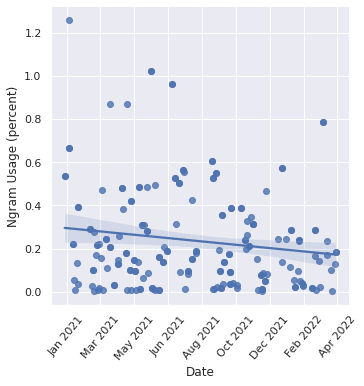

In [3]:
from cdp_data.keywords import plot_ngram_usage_histories
plot_ngram_usage_histories("police", seattle_ds)

We can also use this same function to plot multiple ngrams at the same time to compare how different ngrams compare in their usage against each other. 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 42.81it/s]
/home/maxfield/active/cdp/cdp-data/cdp_data/keywords.py:702: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks_dates)


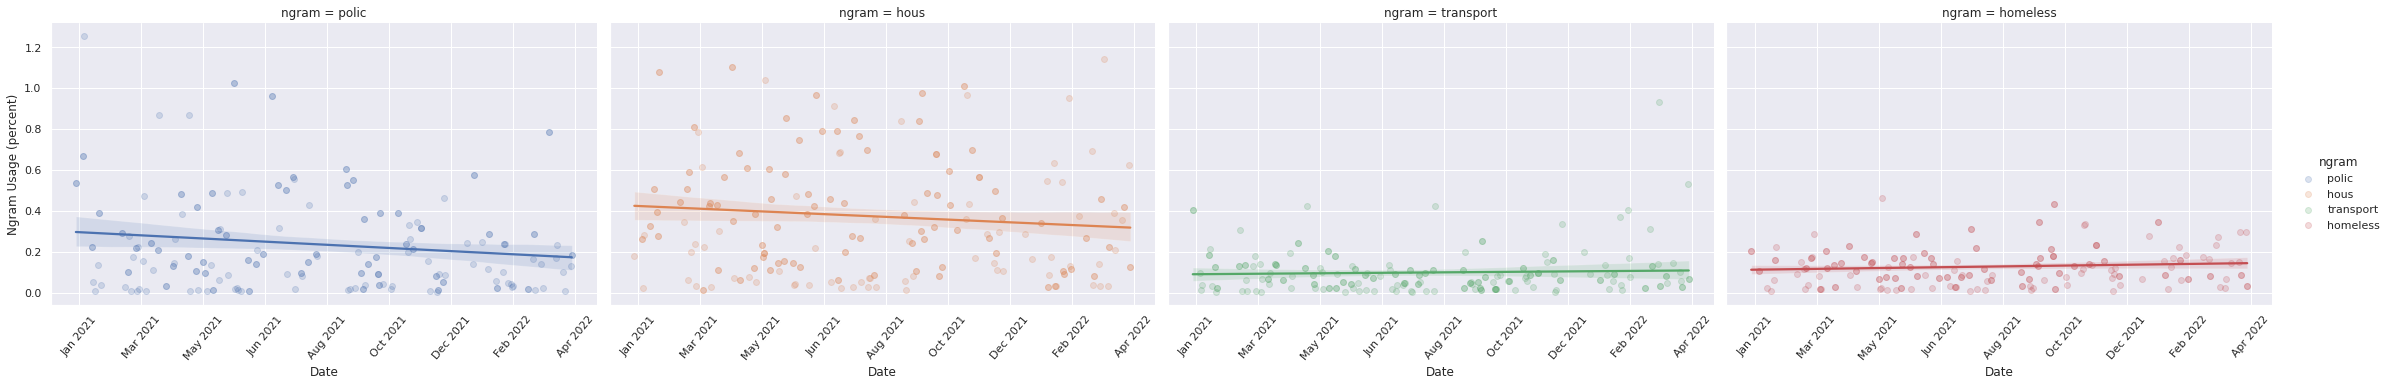

In [4]:
plot_ngram_usage_histories(
    ngram=["police", "housing", "transportation", "homelessness"],
    gram_usage=seattle_ds,
    lmplot_kws=dict(  # extra plotting params
        col="ngram",
        hue="ngram",
        scatter_kws={"alpha": 0.2},
        aspect=1.6,
    ),
)

What would be even more useful would be to plot these terms across instances, an interesting example of such behavior would be to compare how the same terms compare not only to each other but also to a different instance. In this case, let's compare Seattle to King County because Seattle is within King County and we might assume that keywords and discussion are similar.

In [ ]:
# Get multi instance data
ds = compute_ngram_usage_history([
    CDPInstances.KingCounty,
    CDPInstances.Portland,
])
ds = pd.concat([seattle_ds, ds])
ds.to_parquet("keyword_usage.parquet", index=False)

  0%|                                                                                                                                                                   | 0/2 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

In [ ]:
# Load cache
import pandas as pd
ds = pd.read_parquet("keyword_usage.parquet")

In [ ]:
from cdp_data.keywords import plot_ngram_usage_histories
plot_ngram_usage_histories(
    ngram=["police", "housing", "transportation", "homelessness"],
    gram_usage=ds,
    lmplot_kws=dict(  # extra plotting params
        col="infrastructure",
        hue="ngram",
        row="ngram",
        scatter_kws={"alpha": 0.2},
        aspect=1.6,
    ),
)

## Ngram Relevancy Over Time

Also interesting but not useful for comparing ngrams against each other and especially not useful for comparing across instances, is simply plotting the relevancy of ngrams over time.

This is minorly useful if you are simply curious as generally what time periods or events have the highest relevancy for a keyword (i.e. if you were to search for events with a keyword, are there periods of time that have lots of highly relevant events).

In [ ]:
from cdp_data.keywords import get_ngram_relevancy_history

police = get_ngram_relevancy_history("police", infrastructure_slug="cdp-seattle-21723dcf")
police.head()

In [ ]:
from cdp_data.keywords import prepare_ngram_relevancy_history_plotting_data

prepped_police_data = prepare_ngram_relevancy_history_plotting_data(police)
prepped_police_data.head()

In [ ]:
import seaborn as sns
from datetime import datetime

ax = sns.regplot(x="timestamp_posix", y="value", data=prepped_police_data, scatter_kws={"alpha": 0.2})
xticks = ax.get_xticks()
xticks_dates = [datetime.fromtimestamp(x).strftime("%b %Y") for x in xticks]
ax.set_xticklabels(xticks_dates)
ax.tick_params(axis="x", rotation=50)